# TMDB Movie Success Classifier

  


In [1]:
# Standard imports and path variables
import os
import pandas as pd
import numpy as np
import json, ast
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import joblib

movies_path = r"C:\Users\karth\OneDrive\Desktop\4th year\ASBD\project\tmdb_5000_movies.csv"
credits_path = r"C:\Users\karth\OneDrive\Desktop\4th year\ASBD\project\tmdb_5000_credits.csv"

print('Movies path:', movies_path)
print('Credits path:', credits_path)
print('Files exist? movies ->', os.path.exists(movies_path), ', credits ->', os.path.exists(credits_path))

Movies path: C:\Users\karth\OneDrive\Desktop\4th year\ASBD\project\tmdb_5000_movies.csv
Credits path: C:\Users\karth\OneDrive\Desktop\4th year\ASBD\project\tmdb_5000_credits.csv
Files exist? movies -> True , credits -> True


In [2]:
# Load CSVs
movies = pd.read_csv(movies_path)
credits = pd.read_csv(credits_path)
print('movies shape:', movies.shape)
print('credits shape:', credits.shape)

# Merge movies.id with credits.movie_id if available, else on title
if 'id' in movies.columns and 'movie_id' in credits.columns:
    merged = movies.merge(credits, left_on='id', right_on='movie_id', how='left', suffixes=('','_cred'))
else:
    merged = movies.merge(credits, on='title', how='left', suffixes=('','_cred'))
print('merged shape:', merged.shape)

movies shape: (4803, 20)
credits shape: (4803, 4)
merged shape: (4803, 24)


In [3]:
# Basic cleaning and filtering
for col in ['budget','revenue','popularity','runtime','vote_count','vote_average']:
    if col in merged.columns:
        merged[col] = pd.to_numeric(merged[col], errors='coerce')

df = merged.copy()
df = df[(df['budget'] > 0) & (df['revenue'] > 0)].reset_index(drop=True)
print('After filtering budget>0 & revenue>0:', df.shape)

# target
df['success'] = (df['revenue'] > 2 * df['budget']).astype(int)
print('Success distribution:\n', df['success'].value_counts(normalize=True))

After filtering budget>0 & revenue>0: (3229, 24)
Success distribution:
 success
1    0.558687
0    0.441313
Name: proportion, dtype: float64


In [4]:
# Feature engineering helpers
import ast, json

def count_json_list(x):
    if pd.isna(x):
        return 0
    try:
        items = ast.literal_eval(x)
        if isinstance(items, list):
            return len(items)
        return 0
    except Exception:
        try:
            items = json.loads(x)
            return len(items) if isinstance(items, list) else 0
        except Exception:
            return 0

def extract_director(crew_str):
    if pd.isna(crew_str):
        return 0
    try:
        crew = ast.literal_eval(crew_str)
        for member in crew:
            if isinstance(member, dict) and member.get('job','').lower() == 'director':
                return 1
        return 0
    except Exception:
        try:
            crew = json.loads(crew_str)
            for member in crew:
                if isinstance(member, dict) and member.get('job','').lower() == 'director':
                    return 1
            return 0
        except Exception:
            return 0

# numeric features
df['log_budget'] = np.log1p(df['budget'])
df['log_revenue'] = np.log1p(df['revenue'])
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_month'] = df['release_date'].dt.month.fillna(0).astype(int)
df['num_genres'] = df['genres'].apply(count_json_list) if 'genres' in df.columns else 0
df['num_prod_companies'] = df['production_companies'].apply(count_json_list) if 'production_companies' in df.columns else 0
df['num_keywords'] = df.get('keywords', '').apply(count_json_list) if 'keywords' in df.columns else 0
df['cast_count'] = df['cast'].apply(count_json_list) if 'cast' in df.columns else 0
df['has_director'] = df['crew'].apply(extract_director) if 'crew' in df.columns else 0

# overview TF-IDF -> SVD
df['overview'] = df['overview'].fillna('')
tfidf = TfidfVectorizer(max_features=2000, stop_words='english')
X_tfidf = tfidf.fit_transform(df['overview'])
svd = TruncatedSVD(n_components=50, random_state=42)
X_svd = svd.fit_transform(X_tfidf)

feature_cols = ['log_budget','popularity','runtime','vote_count','vote_average',
                'release_month','num_genres','num_prod_companies','num_keywords',
                'cast_count','has_director']

features_num = df[feature_cols].fillna(0).astype(float).reset_index(drop=True)
svd_cols = [f"svd_{i}" for i in range(X_svd.shape[1])]
features_svd = pd.DataFrame(X_svd, columns=svd_cols)
X = pd.concat([features_num, features_svd], axis=1)
y = df['success'].values

print('Feature matrix shape:', X.shape)

Feature matrix shape: (3229, 61)


In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train RandomForestClassifier baseline
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]

print('RandomForest Results:')
print('Accuracy:', accuracy_score(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_proba))
print('\nClassification Report:\n', classification_report(y_test, y_pred))

RandomForest Results:
Accuracy: 0.7352941176470589
ROC AUC: 0.8008699032900812

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.65      0.68       285
           1       0.74      0.80      0.77       361

    accuracy                           0.74       646
   macro avg       0.73      0.73      0.73       646
weighted avg       0.73      0.74      0.73       646



In [6]:
# Optional: CatBoostClassifier (often performs very well on this dataset)
# Uncomment and run if you have catboost installed. To install: pip install catboost
# from catboost import CatBoostClassifier
# cb = CatBoostClassifier(iterations=1000, learning_rate=0.05, depth=6, eval_metric='AUC', verbose=100, random_seed=42)
# cb.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)
# y_pred_cb = cb.predict(X_test)
# y_proba_cb = cb.predict_proba(X_test)[:,1]
# print('CatBoost Results:')
# print('Accuracy:', accuracy_score(y_test, y_pred_cb))
# print('ROC AUC:', roc_auc_score(y_test, y_proba_cb))
# print('\nClassification Report:\n', classification_report(y_test, y_pred_cb))

In [7]:
# Save the RandomForest model + preprocessing objects
model_bundle = {
    'rf_model': rf,
    'tfidf': tfidf,
    'svd': svd,
    'feature_cols': feature_cols,
    'svd_cols': svd_cols
}
joblib.dump(model_bundle, 'rf_tmdb_model_bundle.joblib')
print('Saved model bundle to rf_tmdb_model_bundle.joblib')

Saved model bundle to rf_tmdb_model_bundle.joblib


## Exploratory Data Analysis (EDA)

This section creates visualizations to understand distributions and relationships in the TMDB data:
- Budget / Revenue distributions (log-scaled)
- Budget vs Revenue scatter
- Release month counts
- Top genres by count
- Correlation heatmap for numeric features
- Feature importance from RandomForest (already trained earlier)

Data shape for EDA: (3229, 33)


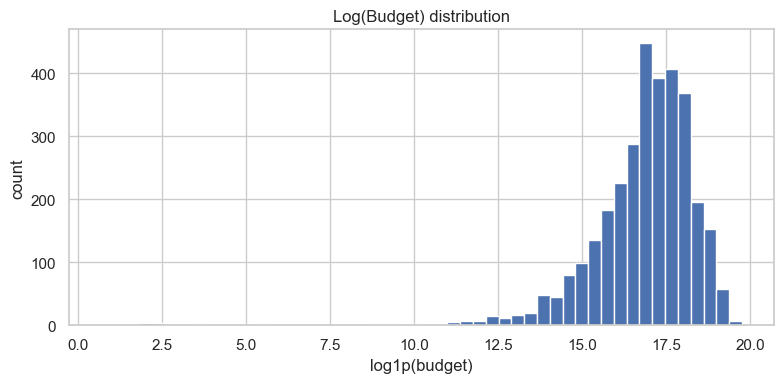

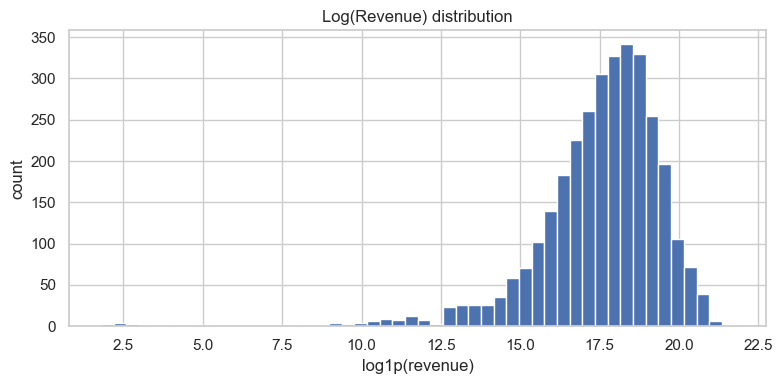

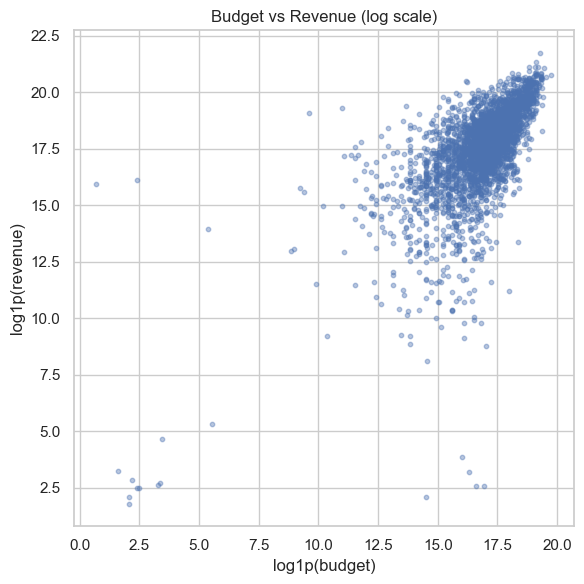

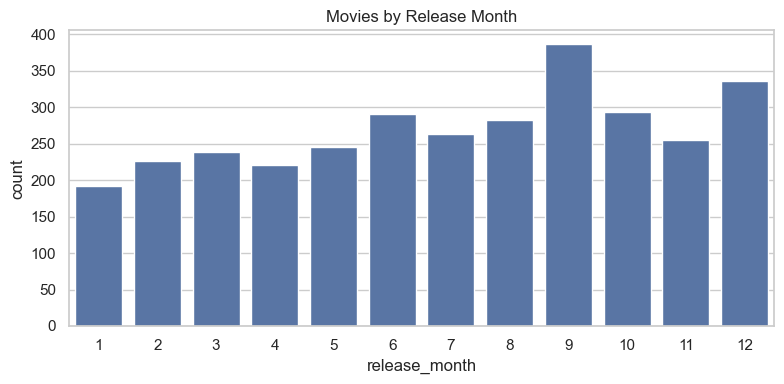

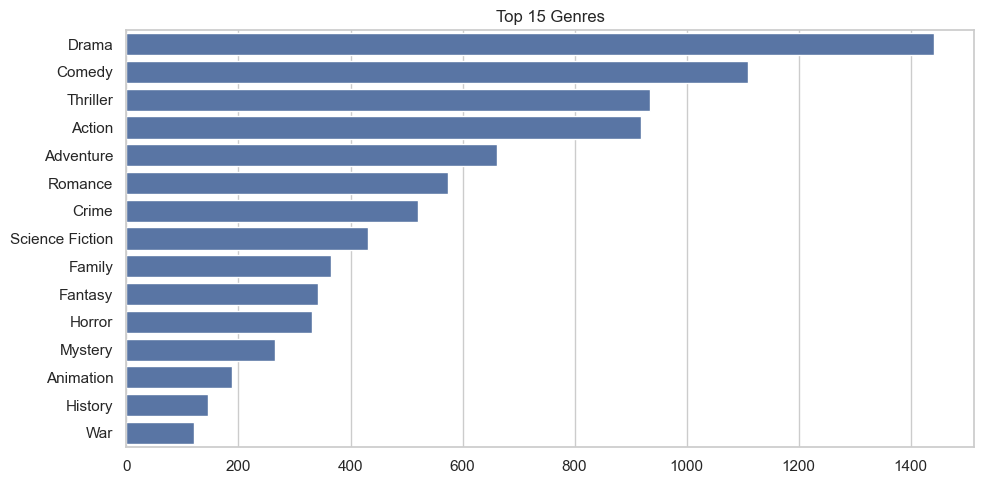

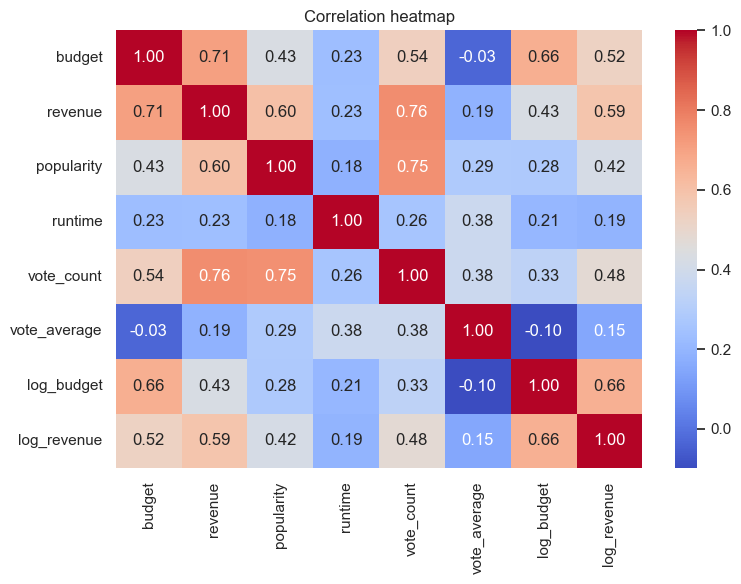

Saved EDA plots: ['budget_vs_revenue.png', 'correlation_heatmap.png', 'log_budget_hist.png', 'log_revenue_hist.png', 'release_month_count.png', 'top_genres.png']


In [8]:
# EDA: plots and saving figures
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set(style='whitegrid', rc={'figure.dpi':100})

# Ensure figures folder
os.makedirs('eda_plots', exist_ok=True)

# Use df from preprocessing section (expects df to be in notebook namespace)
print('Data shape for EDA:', df.shape)

# Log-distributions
plt.figure(figsize=(8,4))
plt.hist(np.log1p(df['budget']), bins=50)
plt.title('Log(Budget) distribution')
plt.xlabel('log1p(budget)')
plt.ylabel('count')
plt.tight_layout(); plt.savefig('eda_plots/log_budget_hist.png'); plt.show()

plt.figure(figsize=(8,4))
plt.hist(np.log1p(df['revenue']), bins=50)
plt.title('Log(Revenue) distribution')
plt.xlabel('log1p(revenue)')
plt.ylabel('count')
plt.tight_layout(); plt.savefig('eda_plots/log_revenue_hist.png'); plt.show()

# Budget vs Revenue scatter (log scale)
plt.figure(figsize=(6,6))
plt.scatter(np.log1p(df['budget']), np.log1p(df['revenue']), alpha=0.4, s=10)
plt.xlabel('log1p(budget)'); plt.ylabel('log1p(revenue)')
plt.title('Budget vs Revenue (log scale)')
plt.tight_layout(); plt.savefig('eda_plots/budget_vs_revenue.png'); plt.show()

# Release month counts
if 'release_month' in df.columns:
    plt.figure(figsize=(8,4))
    sns.countplot(x='release_month', data=df, order=range(1,13))
    plt.title('Movies by Release Month'); plt.tight_layout(); plt.savefig('eda_plots/release_month_count.png'); plt.show()

# Top genres (extract names from genres json string)
import ast, collections
def extract_genre_names(x):
    try:
        items = ast.literal_eval(x)
        return [d.get('name') for d in items if isinstance(d, dict) and 'name' in d]
    except Exception:
        return []

all_genres = []
if 'genres' in df.columns:
    for g in df['genres'].dropna():
        all_genres += extract_genre_names(g)
    genre_counts = collections.Counter(all_genres)
    top_genres = genre_counts.most_common(15)
    genres, counts = zip(*top_genres)
    plt.figure(figsize=(10,5))
    sns.barplot(x=list(counts), y=list(genres))
    plt.title('Top 15 Genres'); plt.tight_layout(); plt.savefig('eda_plots/top_genres.png'); plt.show()

# Correlation heatmap for numeric cols
num_cols = ['budget','revenue','popularity','runtime','vote_count','vote_average','log_budget','log_revenue']
num_cols = [c for c in num_cols if c in df.columns]
plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation heatmap'); plt.tight_layout(); plt.savefig('eda_plots/correlation_heatmap.png'); plt.show()

# Display saved plot files
print('Saved EDA plots:', os.listdir('eda_plots'))

## CatBoost Classifier 



In [9]:
# CatBoost training & evaluation (guarded install)
import sys
try:
    from catboost import CatBoostClassifier, Pool
    has_cat = True
except Exception as e:
    print('CatBoost not found, attempting to install...')
    !{sys.executable} -m pip install catboost --quiet
    try:
        from catboost import CatBoostClassifier, Pool
        has_cat = True
    except Exception as e2:
        print('Failed to install CatBoost. You can install it manually and re-run this cell.'); has_cat = False

if has_cat:
    # Use X_train, X_test, y_train, y_test from training cell (re-run earlier cells if needed)
    cb = CatBoostClassifier(iterations=1000, learning_rate=0.05, depth=6, eval_metric='AUC', random_seed=42, verbose=100, early_stopping_rounds=50)
    # Fit on full numeric+svd features (no categorical declared since we've converted text to svd)
    cb.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)
    y_pred_cb = cb.predict(X_test)
    y_proba_cb = cb.predict_proba(X_test)[:,1]
    from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
    print('CatBoost Results:')
    print('Accuracy:', accuracy_score(y_test, y_pred_cb))
    print('ROC AUC:', roc_auc_score(y_test, y_proba_cb))
    print('\\nClassification Report:\\n', classification_report(y_test, y_pred_cb))
    # Save model
    cb.save_model('catboost_tmdb_model.cbm')
    print('Saved CatBoost model to catboost_tmdb_model.cbm')

CatBoost not found, attempting to install...



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


0:	test: 0.7675463	best: 0.7675463 (0)	total: 146ms	remaining: 2m 26s
100:	test: 0.8204695	best: 0.8253584 (70)	total: 510ms	remaining: 4.54s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8253584099
bestIteration = 70

Shrink model to first 71 iterations.
CatBoost Results:
Accuracy: 0.7445820433436533
ROC AUC: 0.8253584098751032
\nClassification Report:\n               precision    recall  f1-score   support

           0       0.74      0.66      0.69       285
           1       0.75      0.81      0.78       361

    accuracy                           0.74       646
   macro avg       0.74      0.74      0.74       646
weighted avg       0.74      0.74      0.74       646

Saved CatBoost model to catboost_tmdb_model.cbm


## Association Rule Mining (Apriori / mlxtend)

We will create transactions per movie using genres and keywords (if available) and run the Apriori algorithm to find frequent itemsets and association rules (support, confidence, lift).


In [10]:
# Association Rule Mining using mlxtend
import sys
try:
    from mlxtend.frequent_patterns import apriori, association_rules
    from mlxtend.preprocessing import TransactionEncoder
    has_mlxtend = True
except Exception as e:
    print('mlxtend not found, attempting to install...')
    !{sys.executable} -m pip install mlxtend --quiet
    try:
        from mlxtend.frequent_patterns import apriori, association_rules
        from mlxtend.preprocessing import TransactionEncoder
        has_mlxtend = True
    except Exception as e2:
        print('Failed to install mlxtend. Install manually and re-run this cell.'); has_mlxtend = False

if has_mlxtend:
    # Build transactions: combine genres and keywords
    transactions = []
    for idx, row in df.iterrows():
        items = []
        # genres
        try:
            gs = ast.literal_eval(row['genres']) if pd.notna(row['genres']) else []
            items += [g.get('name').strip().lower().replace(' ','_') for g in gs if isinstance(g, dict) and g.get('name')]
        except Exception:
            pass
        # keywords (if exists)
        if 'keywords' in df.columns and pd.notna(row.get('keywords')):
            try:
                ks = ast.literal_eval(row['keywords'])
                items += [k.get('name').strip().lower().replace(' ','_') for k in ks if isinstance(k, dict) and k.get('name')]
            except Exception:
                pass
        # deduplicate per movie
        transactions.append(list(set(items)))
    print('Built', len(transactions), 'transactions. Example:', transactions[:3])

    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df_trans = pd.DataFrame(te_ary, columns=te.columns_)

    # Frequent itemsets with min_support (tunable)
    frequent_itemsets = apriori(df_trans, min_support=0.02, use_colnames=True)
    frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False).reset_index(drop=True)
    print('Top frequent itemsets:'); display(frequent_itemsets.head(10))

    # Association rules
    rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.2)
    rules = rules.sort_values(by=['lift','confidence'], ascending=False).reset_index(drop=True)
    print('Top association rules:'); display(rules.head(15))

    # Save rules to CSV
    rules.to_csv('association_rules_tmdb.csv', index=False)
    print('Saved association rules to association_rules_tmdb.csv')

mlxtend not found, attempting to install...



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Built 3229 transactions. Example: [['anti_war', 'space', 'battle', 'alien', 'romance', 'mind_and_soul', 'soldier', 'society', 'future', 'culture_clash', 'alien_planet', 'science_fiction', 'action', 'futuristic', 'marine', 'love_affair', '3d', 'space_travel', 'cgi', 'fantasy', 'power_relations', 'adventure', 'space_war', 'space_colony', 'tribe'], ['drug_abuse', 'strong_woman', 'exotic_island', 'pirate', 'swashbuckler', "love_of_one's_life", 'traitor', 'ocean', 'afterlife', 'fighter', 'east_india_trading_company', 'shipwreck', 'action', 'aftercreditsstinger', 'ship', 'calypso', 'alliance', 'fantasy', 'adventure'], ['secret_agent', 'sequel', 'mi6', 'united_kingdom', 'adventure', 'action', 'spy', 'based_on_novel', 'crime', 'british_secret_service']]
Top frequent itemsets:


,support,itemsets
0,0.446268,(drama)
1,0.344379,(comedy)
2,0.289873,(thriller)
3,0.284608,(action)
4,0.206875,(adventure)
5,0.180861,(romance)
6,0.163208,(crime)
7,0.142149,"(action, thriller)"
8,0.133788,(science_fiction)
9,0.126045,(family)


Top association rules:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(dystopia),"(science_fiction, action)",0.040260,0.077114,0.026324,0.653846,8.478993,1.0,0.023219,2.666116,0.919063,0.289116,0.624923,0.497606
1,"(science_fiction, action)",(dystopia),0.077114,0.040260,0.026324,0.341365,8.478993,1.0,0.023219,1.457166,0.955764,0.289116,0.313736,0.497606
2,"(family, adventure)",(animation),0.053887,0.058842,0.025705,0.477011,8.106685,1.0,0.022534,1.799577,0.926575,0.295374,0.444314,0.456927
3,(animation),"(family, adventure)",0.058842,0.053887,0.025705,0.436842,8.106685,1.0,0.022534,1.680014,0.931453,0.295374,0.404767,0.456927
4,"(comedy, animation)",(family),0.032828,0.126045,0.030660,0.933962,7.409740,1.0,0.026522,13.234172,0.894404,0.239130,0.924438,0.588603
5,(family),"(comedy, animation)",0.126045,0.032828,0.030660,0.243243,7.409740,1.0,0.026522,1.278049,0.989802,0.239130,0.217558,0.588603
6,(science_fiction),(alien),0.133788,0.021679,0.020749,0.155093,7.154200,1.0,0.017849,1.157904,0.993084,0.154023,0.136370,0.556118
7,(alien),(science_fiction),0.021679,0.133788,0.020749,0.957143,7.154200,1.0,0.017849,20.211624,0.879284,0.154023,0.950524,0.556118
8,(animation),"(family, comedy)",0.058842,0.073088,0.030660,0.521053,7.129148,1.0,0.026359,1.935312,0.913482,0.302752,0.483287,0.470272
9,"(family, comedy)",(animation),0.073088,0.058842,0.030660,0.419492,7.129148,1.0,0.026359,1.621265,0.927521,0.302752,0.383198,0.470272


Saved association rules to association_rules_tmdb.csv


## Pattern Evaluation & Presentation

This section evaluates patterns (rules) by support/confidence/lift, filters actionable rules, and creates simple visualizations (support vs confidence, lift histogram). Finally, it saves a summary CSV and shows top rules.


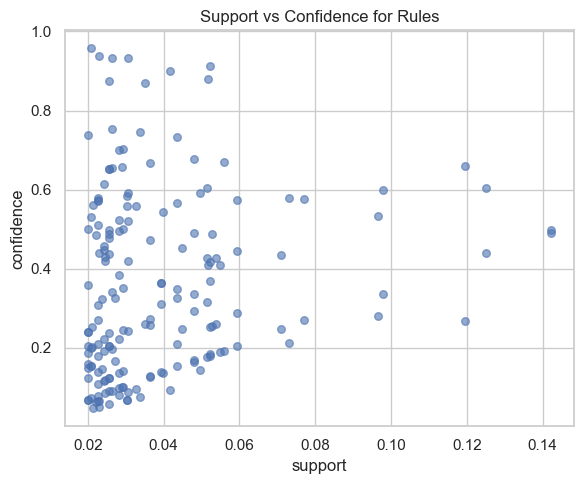

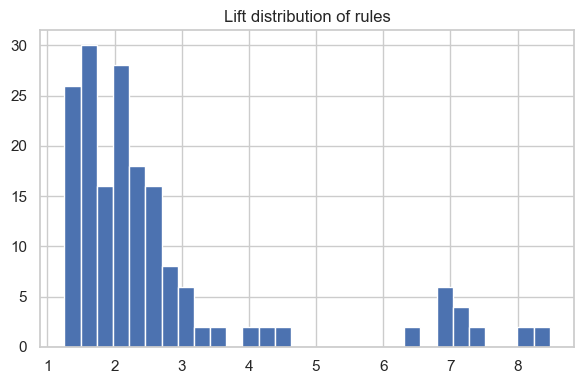

Actionable rules count: 41


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
4,"(comedy, animation)",(family),0.032828,0.126045,0.030660,0.933962,7.409740,1.0,0.026522,13.234172,0.894404,0.239130,0.924438,0.588603
8,(animation),"(family, comedy)",0.058842,0.073088,0.030660,0.521053,7.129148,1.0,0.026359,1.935312,0.913482,0.302752,0.483287,0.470272
9,"(family, comedy)",(animation),0.073088,0.058842,0.030660,0.419492,7.129148,1.0,0.026359,1.621265,0.927521,0.302752,0.383198,0.470272
12,(animation),(family),0.058842,0.126045,0.051719,0.878947,6.973270,1.0,0.044302,7.219626,0.910150,0.388372,0.861489,0.644633
13,(family),(animation),0.126045,0.058842,0.051719,0.410319,6.973270,1.0,0.044302,1.596048,0.980137,0.388372,0.373452,0.644633
16,(dystopia),(science_fiction),0.040260,0.133788,0.034995,0.869231,6.497098,1.0,0.029609,6.623978,0.881578,0.251670,0.849033,0.565402
27,"(thriller, adventure)",(action),0.057293,0.284608,0.052338,0.913514,3.209723,1.0,0.036032,8.271717,0.730287,0.180749,0.879106,0.548705
40,"(science_fiction, action)",(adventure),0.077114,0.206875,0.043667,0.566265,2.737230,1.0,0.027714,1.828593,0.687698,0.181701,0.453132,0.388671
44,"(drama, thriller)",(crime),0.120471,0.163208,0.051409,0.426735,2.614664,1.0,0.031747,1.459695,0.702128,0.221333,0.314925,0.370863
48,"(science_fiction, adventure)",(action),0.059461,0.284608,0.043667,0.734375,2.580301,1.0,0.026744,2.693240,0.651168,0.145361,0.628700,0.443901


Saved actionable rules to actionable_rules_tmdb.csv


In [11]:
# Pattern evaluation visuals
import matplotlib.pyplot as plt
if 'rules' in globals():
    plt.figure(figsize=(6,5))
    plt.scatter(rules['support'], rules['confidence'], s=30, alpha=0.6)
    plt.xlabel('support'); plt.ylabel('confidence'); plt.title('Support vs Confidence for Rules')
    plt.tight_layout(); plt.savefig('eda_plots/support_confidence_scatter.png'); plt.show()

    plt.figure(figsize=(6,4))
    plt.hist(rules['lift'], bins=30)
    plt.title('Lift distribution of rules'); plt.tight_layout(); plt.savefig('eda_plots/lift_hist.png'); plt.show()

    # Filter rules with reasonable support and confidence
    actionable = rules[(rules['support'] >= 0.03) & (rules['confidence'] >= 0.4) & (rules['lift'] >= 1.2)]
    print('Actionable rules count:', actionable.shape[0])
    display(actionable.head(20))
    actionable.to_csv('actionable_rules_tmdb.csv', index=False)
    print('Saved actionable rules to actionable_rules_tmdb.csv')
else:
    print('No rules found — run the Association Rule Mining cell first.')

## Presentation / Summary


The notebook saves:
- `rf_tmdb_model_bundle.joblib` (random forest bundle)
- `catboost_tmdb_model.cbm` (catboost model, if trained)
- `association_rules_tmdb.csv`, `actionable_rules_tmdb.csv`
- EDA plots in `eda_plots/`


In [12]:
# Build a small summary table
summary = {}
# RF metrics if available
if 'y_test' in globals() and 'y_pred' in globals():
    summary['rf_accuracy'] = accuracy_score(y_test, y_pred)
    summary['rf_roc_auc'] = roc_auc_score(y_test, y_proba)
# CatBoost metrics if available
if 'y_pred_cb' in globals():
    summary['catboost_accuracy'] = accuracy_score(y_test, y_pred_cb)
    summary['catboost_roc_auc'] = roc_auc_score(y_test, y_proba_cb)
# Rules summary
if 'rules' in globals():
    summary['n_rules'] = len(rules)
    summary['n_actionable_rules'] = actionable.shape[0] if 'actionable' in globals() else 0

import pandas as pd
summary_df = pd.DataFrame(list(summary.items()), columns=['metric','value'])
display(summary_df)

# List saved files for easy access
import os
files = [f for f in os.listdir('.') if f.endswith(('.joblib','.cbm','.csv'))] + (['eda_plots/'+f for f in os.listdir('eda_plots')] if os.path.exists('eda_plots') else [])
print('Key files in notebook folder:'); display(files)

,metric,value
0,rf_accuracy,0.735294
1,rf_roc_auc,0.800870
2,catboost_accuracy,0.744582
3,catboost_roc_auc,0.825358
4,n_rules,176.000000
5,n_actionable_rules,41.000000


Key files in notebook folder:


['actionable_rules_tmdb.csv',
 'association_rules_tmdb.csv',
 'catboost_tmdb_model.cbm',
 'rf_tmdb_model_bundle.joblib',
 'tmdb_5000_credits.csv',
 'tmdb_5000_movies.csv',
 'eda_plots/budget_vs_revenue.png',
 'eda_plots/correlation_heatmap.png',
 'eda_plots/lift_hist.png',
 'eda_plots/log_budget_hist.png',
 'eda_plots/log_revenue_hist.png',
 'eda_plots/release_month_count.png',
 'eda_plots/support_confidence_scatter.png',
 'eda_plots/top_genres.png']